In [11]:
import os
import zipfile
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import cv2

### Extracting data

In [12]:
url = "https://github.com/srihari-humbarwadi/datasets/releases/download/v0.1.0/data.zip"
filename = os.path.join(os.getcwd(), "data.zip")
keras.utils.get_file(filename, url)


with zipfile.ZipFile("data.zip", "r") as z_fp:
    z_fp.extractall("./")


### utilities

In [13]:
def convert_to_xywh(boxes): 
    '''
        Convert boxes with corner coordinates to xywh coordinates
        
        Arguments: 
            boxes: Tensor of size (num_boxes,4) 
    '''
    print(tf.stack([boxes[:, 1], boxes[:, 0], boxes[:, 3], boxes[:,2]], axis=-1))
    return tf.stack([boxes[:, 1], boxes[:, 0], boxes[:, 3] - boxes[:, 1], boxes[:,2] - boxes[:,0]], axis=-1)


def scale_bbox(boxes, image_shape): 
    
    '''
        Scale boxes with format xywh
    '''
    
    y_scale = image_shape[0]
    x_scale = image_shape[1] 
    return tf.stack([boxes[:, 0] * x_scale, boxes[:, 1] * y_scale, boxes[:, 2] * x_scale, boxes[:,3] * y_scale], axis=-1)


def convert_to_corner(boxes): 
    
    
    '''
        concert a batch of (xmin, ymin, w, h) boxes to (xmin, ymin, xmax, ymax)
    '''
    
    return tf.stack([boxes[:,0], boxes[:,1], boxes[:,0] + boxes[:,2], boxes[:,1] + boxes[:,3]], axis=-1)

In [14]:
(train_dataset, val_dataset), dataset_info = tfds.load(
    "coco/2017", split=["train", "validation"], with_info=True, data_dir="data"
)

autotune = tf.data.experimental.AUTOTUNE
train_dataset

<PrefetchDataset shapes: {image: (None, None, 3), image/filename: (), image/id: (), objects: {area: (None,), bbox: (None, 4), id: (None,), is_crowd: (None,), label: (None,)}}, types: {image: tf.uint8, image/filename: tf.string, image/id: tf.int64, objects: {area: tf.int64, bbox: tf.float32, id: tf.int64, is_crowd: tf.bool, label: tf.int64}}>

### let's visualize some samples

tf.Tensor(
[[0.13464062 0.54380953 0.33742186 0.98651516]
 [0.517875   0.50707793 0.891125   0.8044805 ]
 [0.36971876 0.3264935  0.4431875  0.65203464]], shape=(3, 4), dtype=float32)
rois tf.Tensor(
[[461. 164. 605. 167.]
 [512. 401. 610. 410.]], shape=(2, 4), dtype=float32)
boxes tf.Tensor(
[[ 86.17    251.24    215.95    455.77002]
 [331.44    234.27    570.32    371.66998]
 [236.62001 150.84    283.64    301.24   ]], shape=(3, 4), dtype=float32)
tf.Tensor(
[[0. 0. 0.]
 [0. 0. 0.]], shape=(2, 3), dtype=float32)


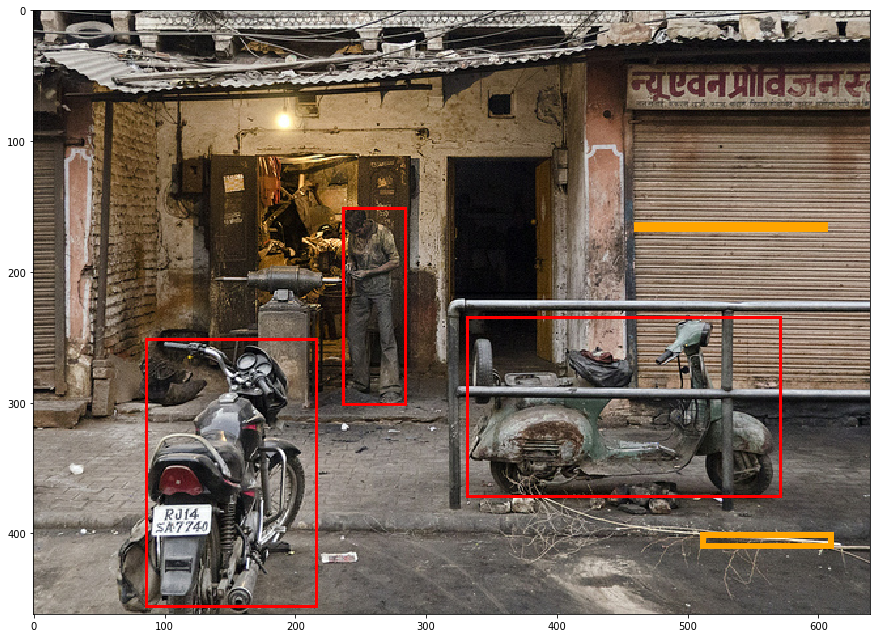

In [97]:
batch = train_dataset.take(1)

for idx, sample in enumerate(batch): 
#     print(sample["image/id"])
    image = sample["image"]
#     print("image shape ", image.shape)
    bboxs = sample["objects"]["bbox"]
#     print("bobxs shape ", bboxs.shape)
    labels = sample["objects"]["label"]
#     print("lables shape ,", labels.shape)
    plt.figure(figsize=(15,15)) 
    plt.imshow(image)
    ax = plt.gca()
    bboxs = convert_to_xywh(bboxs) 
    bboxs = scale_bbox(bboxs, (image.shape[0], image.shape[1]))
           
    rois = ROI().generate_roi(image.numpy(), 2)
    print(compute_iou(rois, bboxs))
            
    # generate roi 
    for roi in rois: 
        rect2 = plt.Rectangle((roi[0], roi[1]), roi[2], roi[3],linewidth=6,edgecolor='orange',facecolor='none')
        ax.add_patch(rect2)

    for bbox, label in zip(bboxs, labels): 
        rect = plt.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3],linewidth=3,edgecolor='r',facecolor='none')
        ax.add_patch(rect)
    break


In [58]:
class ROI: 
    
    '''
        class responsible for generating ROI using Selective Search
        ROI's shapes : x, y, w, h
    '''
    
    
    def __init__(self, resize_width=96, resize_height=96): 
        self.height = resize_width 
        self.width = resize_height
        
    def generate_roi(self, image, roi_nb): 
        '''
            return roi_nb ROI for the image of shape : x, y, w, h
            Arguments: 
                image : the actual sample image 
                roi_nb : the number of roi to extract from the image
        '''
        
        ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
        ss.setBaseImage(image)
        ss.switchToSelectiveSearchFast()
        rects = ss.process()[:roi_nb]
        
        return tf.cast(tf.stack([rects[:,0], rects[:,1], rects[:,2], rects[:,3]], axis=-1), dtype=tf.float32)

In [94]:
def compute_iou(rois, boxes): 
    
    '''
        compute the pairwise IOU between rois and boxes and return a matrix of all iou score 
        where the coefficient (ith,jth) of the ith row, jth colomun is the iou score between the ith roi and jth boxe
    '''
    
    # convert all boxes and rois to corner coordinates
    rois = convert_to_corner(rois) 
    boxes = convert_to_corner(boxes)
    
    print("rois", rois)
    print("boxes", boxes)
    
    # getting minmum coordinates between all rois and each of the gt boxes
    
    xmin1, ymin1, xmax1, ymax1 = tf.split(value=rois, num_or_size_splits=4, axis=1) 
    xmin2, ymin2, xmax2, ymax2 = tf.split(value=boxes, num_or_size_splits=4, axis=1)
    
    x_min = tf.maximum(xmin1, tf.transpose(xmin2))
    y_min = tf.maximum(ymin1, tf.transpose(ymin2)) 
    
    x_max = tf.minimum(xmax1, tf.transpose(xmax2)) 
    y_max = tf.minimum(ymax1, tf.transpose(ymax2))
    
    width = tf.maximum(0.0, x_max - x_min)
    height = tf.maximum(0.0, y_max - y_min) 
    
    intersection = width * height
        
    
    return intersection
    

In [20]:
a = np.random.randn(2, 4)
b = np.random.randn(10, 4)
print(a) 
print() 
print(b)

[[-0.95051643 -1.46265568 -1.06585857 -0.45448101]
 [ 0.40741301 -0.1822896   0.42208206 -0.75885556]]

[[-0.26523594  1.1422445   0.71357185  1.3727236 ]
 [ 0.58784021  1.53024546  1.30690133 -1.58764938]
 [ 2.05324993  1.18282335  0.33967348 -0.06321955]
 [ 1.82467076 -0.95842942  0.58923435 -0.9817307 ]
 [-0.46783823  1.49886305  2.07882409 -0.31492622]
 [-0.22996461 -0.64595878  0.22699018 -2.65210301]
 [ 0.23037896  0.31136851 -0.86633408  0.17282306]
 [ 1.31468798  0.786066    1.07861625  0.83711907]
 [-0.05140596  0.0904748   0.40919186 -0.94219921]
 [ 1.92897685 -0.38073409  1.68094916  1.24270725]]


In [23]:
tf.minimum(a[:, None, :2], b[:, :2])

<tf.Tensor: shape=(2, 10, 2), dtype=float64, numpy=
array([[[-0.95051643, -1.46265568],
        [-0.95051643, -1.46265568],
        [-0.95051643, -1.46265568],
        [-0.95051643, -1.46265568],
        [-0.95051643, -1.46265568],
        [-0.95051643, -1.46265568],
        [-0.95051643, -1.46265568],
        [-0.95051643, -1.46265568],
        [-0.95051643, -1.46265568],
        [-0.95051643, -1.46265568]],

       [[-0.26523594, -0.1822896 ],
        [ 0.40741301, -0.1822896 ],
        [ 0.40741301, -0.1822896 ],
        [ 0.40741301, -0.95842942],
        [-0.46783823, -0.1822896 ],
        [-0.22996461, -0.64595878],
        [ 0.23037896, -0.1822896 ],
        [ 0.40741301, -0.1822896 ],
        [-0.05140596, -0.1822896 ],
        [ 0.40741301, -0.38073409]]])>

In [169]:
c,d, e, f = tf.split(b, num_or_size_splits=4, axis=1)
tf.minimum(c, e)

<tf.Tensor: shape=(2, 1), dtype=float64, numpy=
array([[-0.46464624],
       [-1.28707654]])>

In [ ]:
class LabelEncoder: 
    
    '''        This class has operations to generate targets for a batch of samples which
        is made up of the input images, bounding boxes for the objects present and
        their class ids.
    '''
    
    def __init__(self): 
        roi = ROI()
        
    def _match_roi_boxes(self, rois, gt_boxes, match_iou=0.5, ignore_iou=0.4): 
        
        '''
            Matches ground truth boxes to rois boxes based on IOU
        '''
        
    
    